In [2]:
import logging
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
%load_ext autoreload

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-02-16 14:50:59,100 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-02-16 14:50:59,102 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-02-16 14:51:01.688999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 14:51:07.788199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Data

In [4]:
# experiment specific
result_base_dir = "collinear_BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_threshold_missabthres0.5_convergence_NoIntercept_pred_PScosDist"

In [5]:
# edit experiment specific data path and config
import json

result_parent_dir = "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
MS1Scans_NoArray_path = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
    "BBM_647_P241_02_07_ssDDA_MIA_001_MS1Scans_NoArray.csv"
)
result_dir = os.path.join(result_parent_dir, result_base_dir)
report_dir = os.path.join(result_dir, "report")
with open(os.path.join(result_dir, "param.json"), mode="r", encoding="utf-8") as file:
    config = json.load(file)
output_file = os.path.join(result_dir, "output")  # filename
maxquant_file_exp = config["MQ_exp_path"]
maxquant_file_ref = os.path.join(result_dir, "maxquant_result_ref.pkl")

In [8]:
# Load data
ms1scans_no_array = pd.read_csv(MS1Scans_NoArray_path)
ms1scans_no_array["scan_number"] = ms1scans_no_array.index.astype(int)
maxquant_result_ref = pd.read_pickle(filepath_or_buffer=maxquant_file_ref)
maxquant_result_ref.index = maxquant_result_ref["id"]
maxquant_result_exp = pd.read_csv(
    filepath_or_buffer=maxquant_file_exp, sep="\t")
peak_results_matched = pd.read_csv(
    os.path.join(result_dir, "peak_results_matched.csv"))
peak_results = pd.read_csv(os.path.join(result_dir, "peak_results.csv"))
peak_selection_result_dir = os.path.join(report_dir, "peak_selection_4d_input")

peak_results_search_range = pd.read_csv(
    os.path.join(result_dir, "peak_results_search_range_pred_score.csv")
)

In [7]:
# Load collinear precursors
collinear_precursors = np.load(
    output_file + "_collinearPrecursors.npy", allow_pickle=True
)

In [46]:
collinear_precursors_df = pd.DataFrame(
    collinear_precursors, index=maxquant_result_ref.id
)

# Apply peak selection models
peak_results mark the annotated data:
- matched: binary classification task


## Peak sequence classification

In [38]:
from utils.tools import match_time_to_scan

maxquant_result_ref = match_time_to_scan(
    maxquant_result_ref, ms1scans_no_array=ms1scans_no_array, time_cols=[
        "predicted_RT"]
)

In [57]:
from postprocessing.peak_selection import rank_among_collinear_candidates

# Function to map each value in a list


def map_values(lst, col_index):
    if isinstance(lst, list):
        item = maxquant_result_ref["predicted_RT_scan"].get(lst.name)
        if item is None:
            return np.nan
        list_without_item = [
            maxquant_result_ref["predicted_RT_scan"].get(val) - col_index for val in lst
        ]
        return rank_among_collinear_candidates(item, list_without_item)
    else:
        print("NAN")
        return np.nan


# Apply function to DataFrame
mapped_df = collinear_precursors_df.iloc[0:100].applymap(
    lambda x: map_values(x, col_index=x.name)
)

AttributeError: 'float' object has no attribute 'name'

In [30]:
peak_results_search_range_filtered = peak_results_search_range[
    peak_results_search_range["pred_score"] >= 0.4
]

In [10]:
# group by id and count the size of each group
one_peak_precursor = (
    peak_results_search_range_filtered.groupby("id").size().reset_index(name="count")
)

# filter groups with size = 1
one_peak_precursor = one_peak_precursor[one_peak_precursor["count"] == 1].set_index(
    "id"
)

# set y_pred = 1 for the filtered groups
one_peak_precursor_index = one_peak_precursor.index
peak_results_search_range_filtered.loc[
    peak_results_search_range_filtered["id"].isin(one_peak_precursor_index), "y_pred"
] = 1

/tmp/ipykernel_78062/1275249122.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_results_search_range_filtered.loc[


In [21]:
from itertools import chain


def get_collinear_precursors_in_peak(p_id, start_scan, end_scan):
    collinear_precursors_in_peak = collinear_precursors_df.loc[
        p_id, start_scan:end_scan
    ]
    # print(collinear_precursors_in_peak.dropna().values)
    return set(chain(*collinear_precursors_in_peak.dropna().values))

In [27]:
# Function to get length of list or NaN
def get_length_or_nan(val):
    if isinstance(val, list):
        return len(val)
    else:
        return np.nan


# Apply function to DataFrame
n_collinear = collinear_precursors_df.iloc[0:10000].applymap(get_length_or_nan)

# Get distribution of lengths
distribution = n_collinear.stack().value_counts().sort_index()

<Axes: title={'center': 'Distribution of Collinear Precursors'}>

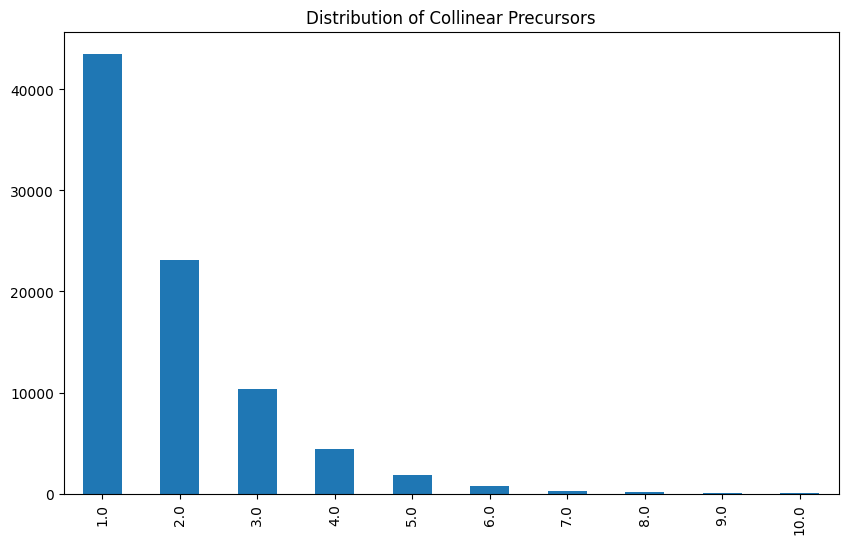

In [29]:
distribution.plot(
    kind="bar", figsize=(10, 6), title="Distribution of Collinear Precursors"
)

In [23]:
p_id = 0
p_peaks = peak_results_search_range_filtered.loc[
    peak_results_search_range_filtered["id"] == p_id
]
for _, peak in p_peaks.iterrows():
    print(peak["start_scan"], peak["end_scan"])
    get_collinear_precursors_in_peak(p_id, peak["start_scan"], peak["end_scan"])

694 699


{83359, 162609, 182339}

706 713


{83359, 182339}

713 721


{83359, 182339}

715 721


{83359, 182339}

745 763


{83359, 143552, 160271, 165651, 182339}

In [71]:
from itertools import chain

non_na_values = collinear_precursors_df.loc[0, :].notna()
collinear_0 = collinear_precursors_df.loc[0,
                                          non_na_values.index[non_na_values]]
set(list(chain(*collinear_0.values)))

{32, 10705, 79723, 83359, 85766, 90314, 143552, 160271, 162609, 165651, 182339}

# Compare quant

In [13]:
top_1_peak = get_top_n_scored_peaks_by_precursor(pred_df, top_n=1)

In [14]:
sum_peak = pd.read_csv(os.path.join(result_dir, "sum_peak.csv"))

In [15]:
peak_results_cls = pd.merge(
    left=peak_results_matched,
    right=top_1_peak[["y_pred_prob", "y_pred"]],
    left_index=True,
    right_index=True,
    how="left",
)

In [16]:
%autoreload 2
def aggregate_intensity(df, threshold=0.05):
    df["peak_intensity_auc"] = df.apply(
        lambda row: row["peak_intensity_auc"] if row["y_pred"] > 0 else 0, axis=1
    )
    result = df.groupby("id")["peak_intensity_auc"].sum().reset_index()
    return result


sum_peak_cls = aggregate_intensity(peak_results_cls, threshold=0.05)

<Axes: >

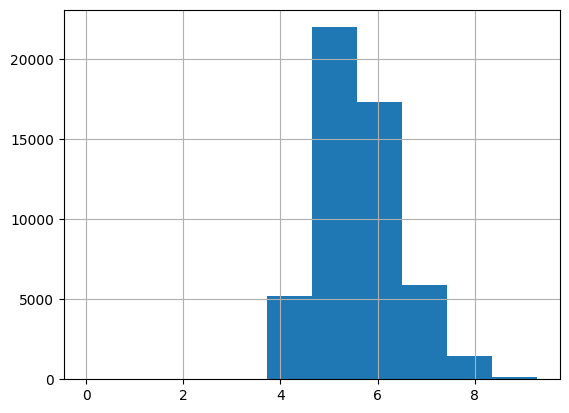

In [17]:
np.log10(sum_peak_cls.peak_intensity_auc + 1).hist()

# Result Evaluation

In [18]:
sum_peak_cls_aligned = (
    pd.merge(
        left=maxquant_result_ref[["id"]],
        right=sum_peak_cls,
        left_index=True,
        right_on="id",
        how="left",
    )
    .drop(["id", "id_x", "id_y"], axis=1)
    .rename(columns={"peak_intensity_auc": "AUCActivationPeakCls"})
)

In [19]:
from result_analysis.result_analysis import SBSResult

sbs_result = SBSResult(
    maxquant_ref_df=maxquant_result_ref,
    maxquant_exp_df=maxquant_result_exp,
    sum_peak=sum_peak_cls_aligned,
    sum_raw=sum_peak,
)

2024-02-09 15:55:53,012 - result_analysis.compare_maxquant - INFO - RT overlap counts: full_overlap       17185
no_overlap          1469
partial_overlap      532
Name: RT_overlap, dtype: int64


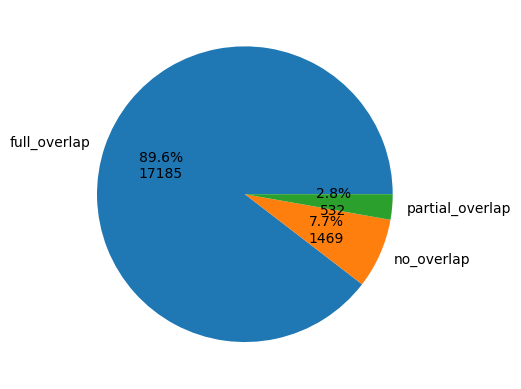

2024-02-09 15:55:53,117 - result_analysis.compare_maxquant - INFO - Removing 2001 entries with RT_overlap ['full_overlap'], 17185 entries left.
2024-02-09 15:55:53,123 - result_analysis.result_analysis - INFO - Drop all duplicated pcm. 17185 -> 17009


Data:  Intensity_log AUCActivationPeakCls_log , slope =  0.69 , intercept =  0.318 , PearsonR =  0.442 , SpearmanR =  0.377


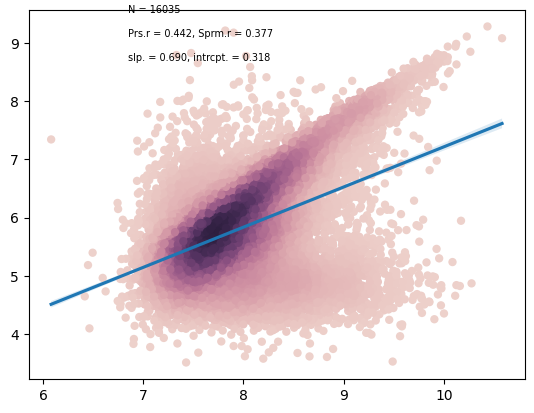

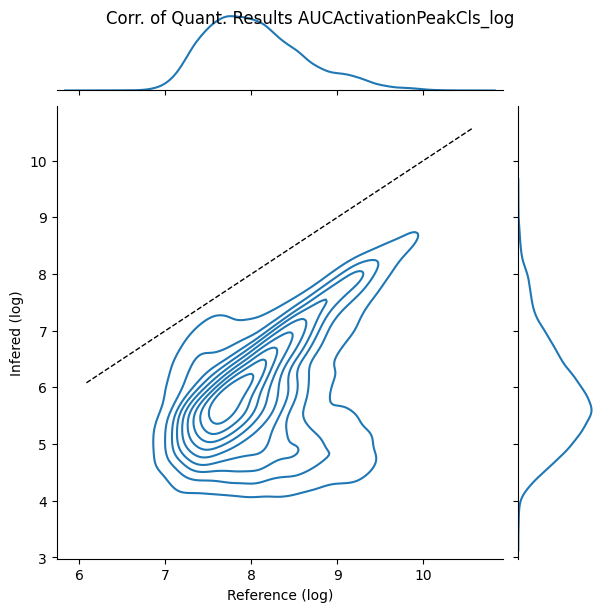

In [20]:
sbs_result.compare_with_maxquant_exp_int(
    filter_by_rt_overlap=["full_overlap"], handle_mul_exp_pcm="drop", save_dir=None
)
sbs_result.plot_intensity_corr(inf_col="AUCActivationPeakCls")

Data:  Intensity_log AUCActivationPeak_log , slope =  0.696 , intercept =  0.043 , PearsonR =  0.453 , SpearmanR =  0.391


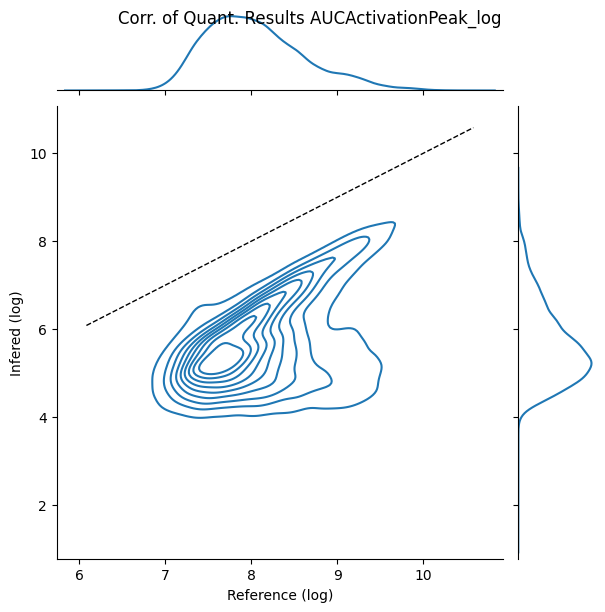

In [26]:
sbs_result.plot_intensity_corr(inf_col="AUCActivationPeak", contour=True)

/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py:368: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ref_df_non_zero["precursor"] = self.ref_df_non_zero[


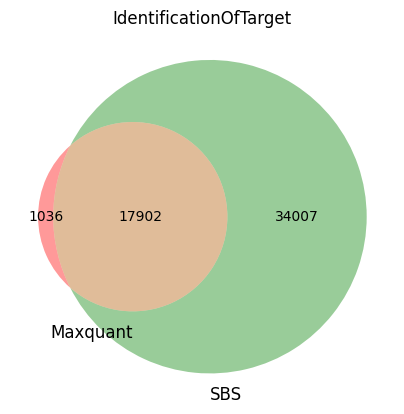

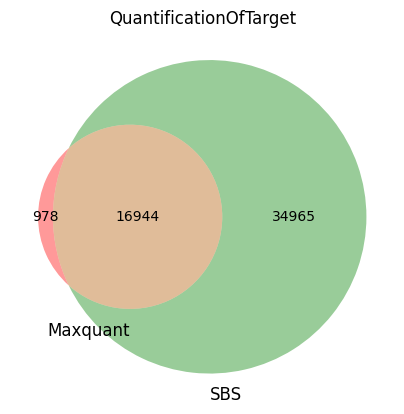

In [22]:
sbs_result.plot_overlap_with_MQ(save_dir=None)